# Sorghastrum nutans characteristics
Found in the entire U.S. east of the rocky mountains, but seems to be concentrated in the southeast and moving northward over time. Generally found in tallgrass prairies.


| Value | Min | Max |
| --- | --- | --- |
| Annual precipitation | 11 | 45 |
| pH | 4.8 | 8.0 |

USDA Natural Resources Conservations Service. Plant Guide: Indiangrass. Accessed February 26, 2025 from https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip 

For soil data: rooting depth averages around 70 cm.

 Brown, R. N., Percivalle, C., Narkiewicz, S., & DeCuollo, S. (2010). Relative Rooting Depths of Native Grasses and Amenity Grasses with Potential for Use on Roadsides in New England. HortScience horts, 45(3), 393-400. Retrieved Feb 26, 2025, from https://doi.org/10.21273/HORTSCI.45.3.393

In [2]:
%conda install skfuzzy

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - skfuzzy

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [3]:
from math import floor, ceil

import cartopy.crs as ccrs
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import skfuzzy
import xarray as xr

In [4]:
grassland_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources/shp"
    "/S_USA.NationalGrassland.zip")
grassland_gdf = gpd.read_file(grassland_url)
grassland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NATIONALGR  20 non-null     object  
 1   GRASSLANDN  20 non-null     object  
 2   GIS_ACRES   20 non-null     float64 
 3   SHAPE_AREA  20 non-null     float64 
 4   SHAPE_LEN   20 non-null     float64 
 5   geometry    20 non-null     geometry
dtypes: float64(3), geometry(1), object(2)
memory usage: 1.1+ KB


## Site description

I picked the Oglala grassland for this example because it is a mixed-grass prairie closer to the edge of sorghastrum nutans' domain. This makes it marginal habitat for this grass species, and more likely we'll see climate-related changes.

In [5]:
oglala_gdf = grassland_gdf[grassland_gdf.GRASSLANDN.str.contains('Oglala')]
(
    oglala_gdf
    .to_crs(ccrs.Mercator())
    .hvplot(tiles='EsriNatGeo', line_width=3, fill_color=None)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]

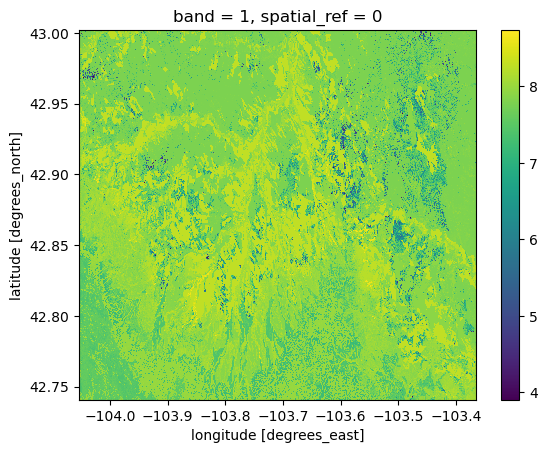

In [6]:
xmin, ymin, xmax, ymax = oglala_gdf.total_bounds
tiles = []
for lat_min in range(floor(ymin), ceil(ymax)):
    for lon_min in range(floor(xmin), ceil(xmax)):
        lat_max, lon_max = lat_min + 1, lon_min + 1
        ph_url = (
            "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
            "/ph/mean/60_100"
            f"/lat{lat_min}{lat_max}_lon{lon_min}{lon_max}.tif")
        tiles.append(rxr.open_rasterio(ph_url))

ph_da = rxrmerge.merge_arrays(tiles).rio.clip_box(*oglala_gdf.total_bounds)
ph_da.plot()

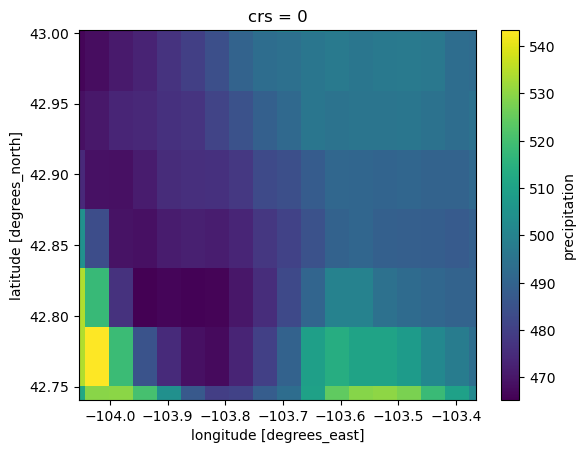

In [ ]:
year_min, year_max = 2011, 2040
model = "BNU-ESM"
emissions = 'rcp45'
variable = 'pr'
periods = []
buffer_bounds = None
for start_year in range(year_min, year_max, 5):
    end_year = start_year + 4
    climate_url = (
        "http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2"
        f"/{model}/macav2metdata_{variable}_{model}_r1i1p1_{emissions}"
        f"_{start_year}_{end_year}_CONUS_monthly.nc")
    period_da = (
        xr.open_dataset(climate_url, mask_and_scale=True)
        .squeeze()
        .precipitation)
    period_da = period_da.assign_coords(lon=(period_da.lon + 180) % 360 - 180)
    period_da = period_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    if buffer_bounds is None:
        oglala_gdf_reproj = oglala_gdf.to_crs(period_da.rio.crs)
        xmin, ymin, xmax, ymax = oglala_gdf_reproj.total_bounds
        b = .1
        buffer_bounds = [xmin - b, ymin - b, xmax + b, ymax + b]
    periods.append(period_da.rio.clip_box(*buffer_bounds))

precip_da = (
    xr.concat(periods, dim='time')
    .resample({'time': 'Y'})
    .sum()
    .rio.write_crs(4326)
    .rio.reproject_match(precip_min_da))

precip_min_da = precip_da.min('time')
precip_max_da = precip_da.max('time')
precip_mean_da = precip_da.mean('time')
precip_mean_da.plot()

(array([ 78516., 347700., 938700., 698580., 145200.,  25500.,  34224.,
         27600.,   5400.,  27900.]),
 array([300.802948  , 307.90731812, 315.01168823, 322.11605835,
        329.22042847, 336.32476807, 343.42913818, 350.5335083 ,
        357.63787842, 364.74224854, 371.84661865]),
 <BarContainer object of 10 artists>)

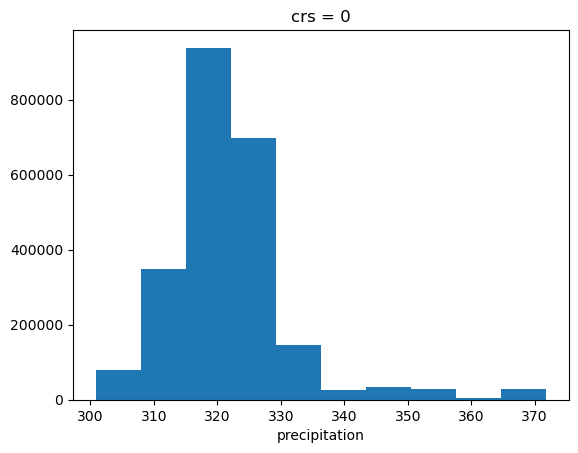

In [8]:
precip_min_da.plot.hist()

In [9]:
# precip 11-45 (in) 279-1143
# ph 4.8-8
precip_suit = ((precip_min_da > 310) & (precip_max_da < 825))
ph_suit = ((precip_min_da > 4.8) & (precip_min_da < 8))

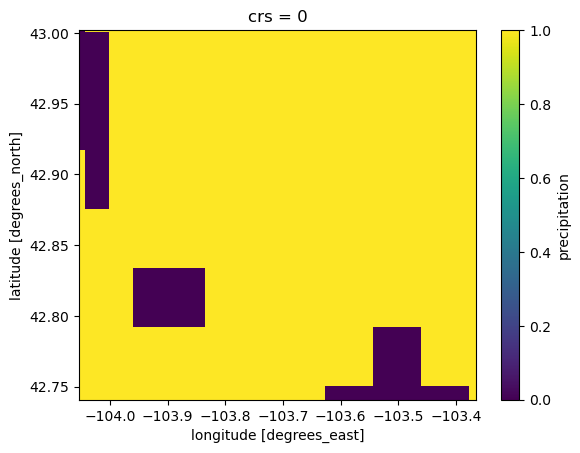

In [10]:
precip_suit.plot()

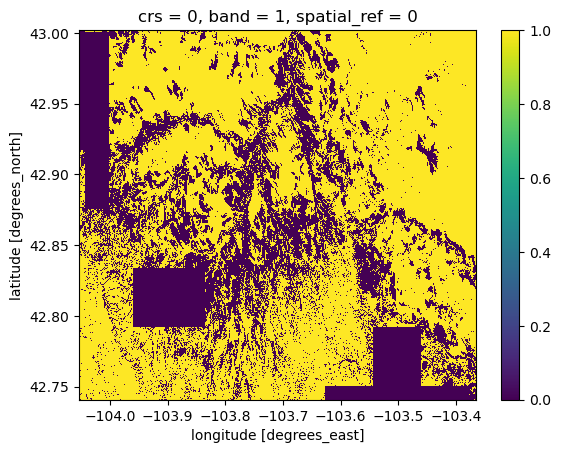

In [11]:
(precip_suit * ph_suit).plot()

In [12]:
ph_da.values

array([[[7.673235 , 7.673235 , 7.7481956, ..., 7.8109965, 7.8082285,
         7.8082285],
        [7.7466683, 7.7466683, 7.694289 , ..., 7.8104267, 7.8369613,
         7.8369613],
        [7.350517 , 7.350517 , 7.774949 , ..., 7.8091993, 7.8091993,
         7.8104267],
        ...,
        [7.97541  , 7.97541  , 7.6308136, ..., 8.054024 , 8.049429 ,
         8.036055 ],
        [7.992031 , 7.992031 , 7.56514  , ..., 8.074032 , 8.05065  ,
         8.065739 ],
        [7.5326257, 7.97568  , 7.9760065, ..., 8.076305 , 8.076305 ,
         8.001007 ]]], dtype=float32)

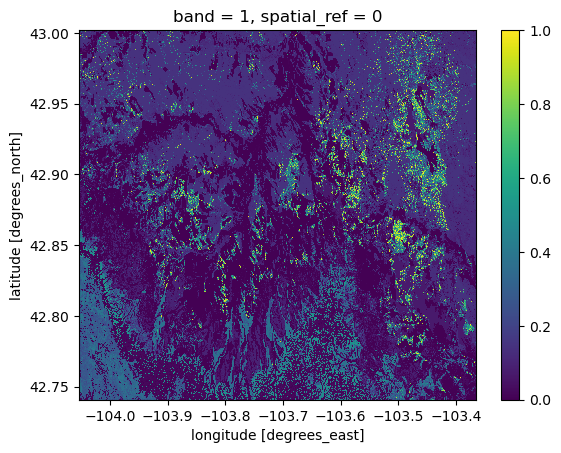

In [15]:
shape = ph_da.values.shape
ph_fuzz = ph_da.copy()
ph_fuzz.values = (
    np.reshape(
        skfuzzy.trimf(ph_da.values.flatten(), [4.8, (4.8 + 8)/2, 8]),
        shape)
)
ph_fuzz.plot()


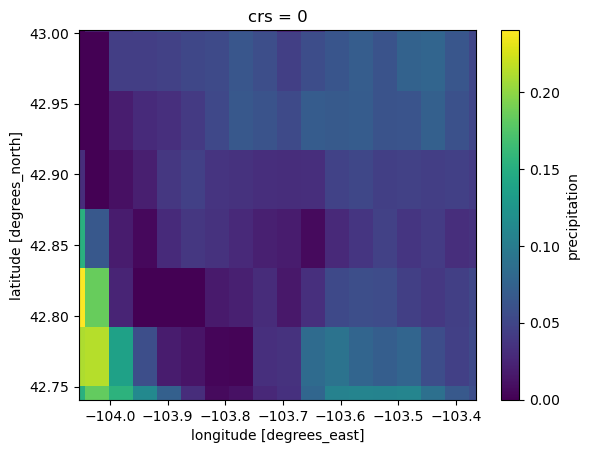

In [16]:
shape = precip_min_da.values.shape
precip_min_fuzz = precip_min_da.copy()
precip_min_fuzz.values = (
    np.reshape(
        skfuzzy.trimf(precip_min_da.values.flatten(), 
                      [310, (310 + 825)/2, 825]),
        shape)
)
precip_min_fuzz.plot()

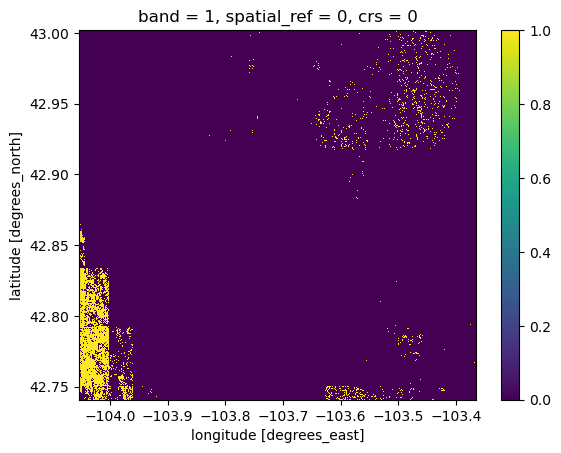

In [24]:
((ph_fuzz * precip_min_fuzz) > .05).plot()